In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# IMPORTS

In [0]:
import datetime
import os
import random
import statistics as stats
import numpy as np
import scipy.signal as scsig
from scipy.io import loadmat
from scipy.signal import medfilt
import pywt
from pywt import wavedec
#from ecgdetectors import Detectors
#import hrv
import matplotlib
import matplotlib.pyplot as plt
#from PIL import Image
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from keras.utils import to_categorical

import keras.backend as kbend

# GLOBAL DECLEARATIONS

In [28]:
#===========================================================================================================
# 1 DEFINE DIRECTORIES
#===========================================================================================================
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data'
# global annotation and mapping, common for all ECG from https://physionet.org/about/database/
global_annot = os.path.join(global_dir, 'annotations.txt' ) 
global_matdir = os.path.join(global_dir, 'db_mat')

global_npydir = os.path.join(global_dir, 'db_npy')
os.makedirs(global_npydir , exist_ok = True) 

global_modeldir = os.path.join(global_dir, 'db_model') 
os.makedirs(global_modeldir , exist_ok = True) 

global_datadir = os.path.join(global_dir, 'db_dataset') 
os.makedirs(global_modeldir , exist_ok = True) 

print('GLOBAL DIR :: '+global_dir)
print('GLOBAL MAT DIR :: '+global_matdir)
print('GLOBAL NPY DIR :: '+global_npydir)
print('GLOBAL MODEL DIR :: '+global_modeldir)
print('GLOBAL DATA DIR :: '+global_datadir)
print('GLOBAL ANNOTATIONS :: '+global_annot)

#===========================================================================================================
# 2 Define annotation mapping dictionary (from global_annot)
# view this file on drive :: https://drive.google.com/open?id=1edhzatX7D3Uo03-d08Lksp807ULlcpgo
#=========================================================================================================== 
g_map_data = np.loadtxt(global_annot, dtype='str',delimiter="\t")
g_map={}
print('ANNOTATION MAPPING :: ')
for a in g_map_data:
    g_map[a[0]]= int(a[1])
    print(str(a[0])+'\t'+str(a[1])+'\t'+str(a[2]))
    #a[0] = orignal mit label (char)
    #a[1] = mapped integer label (int)
    #a[2] = description (str)
print('')
g_map_keys = g_map.keys()
print('Annotations : [' + str(len(g_map_keys))+'] :: ' + str(g_map_keys))
def mapstd(peak_label):
    res = np.zeros(len(peak_label),dtype='int')
    for i in range(0, len(peak_label)):
        res[i] = g_map[peak_label[i]]
    return res

g_LMAX = np.max(np.array(list(g_map.values()))) # this is max mapping value starting from 0
g_LMIN = -1 # this means unmapped (RR beat), 
#anything less than g_LMIN is unmapped(Non RR beat) and anythone greater is mapped(RR beat)

print('Integer Label Range [ '+str(g_LMIN)+ ' : '+str(g_LMAX)+' ]')
#===================================================================================================================
print(datetime.datetime.now())
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================
#===================================================================================================================

def view_beat(fig_n, rec, peak, signal_data_type):
    
    ant = rec.read_data(g_BEAT_POSTFIX)
    iant = ant[:,0].astype(int)
    rant = np.where(iant==peak)[0][0]
    ffi = iant[rant-1]
    tti = iant[rant+1]


    isig = (rec.read_data(signal_data_type)[ffi:tti])/(rec.gain)
    isig_dur = (tti-ffi) 
    plt.figure(fig_n, figsize = (5*(isig_dur/rec.db.srate), 6) )
    plt.ylim(plotdim_bylim)
    #plt.xlim(0,isig_dur)
    plt.plot(isig)
# PARAMS
# fixed dimesion of 1 beat morphological
# first downsample to a basic sampling rate then transform
BASIC_SRATE = 128 #Hz
class ecg_binfo:
    def __init__(self, rec):
        self.israte = rec.db.srate
        self.rec = rec # the record object
        self.sr_ratio = BASIC_SRATE/self.israte
        rr_peaks_ants = rec.read_data(g_BEAT_POSTFIX)       # orignal ant file [ *  '625310' 'N' * ]
        # slice array
        rr_peaks_int = rr_peaks_ants[:,0].astype('int')     # col0 : samples * 62531 *  <---------------- not excluded
        rr_ants_str = rr_peaks_ants[:,1]                    # col1 : labels * 'N' *     <---------------- not excluded
        # excluded first and last

        # start of madarchodh section
        #print(rr_peaks_int.shape)
        self.rr_peaks = rr_peaks_int[1:-1]                       # col0 : samples (int) 62531 ==>==>==> sample# (orignal)
        self.rr_prev = rr_peaks_int[0:-2]                       # prev R peak (in samples)
        self.rr_next = rr_peaks_int[2:]                                           # next R peak (in samples)
        self.nos_rr_peaks = len(self.rr_peaks)              # no fo RR peaks (excluding first and last)
        #print(self.rr_peaks.shape)
        #print(self.rr_prev.shape)
        #print(self.rr_next.shape)
        # end of madarchodh section

        self.rr_labels = rr_ants_str[1:-1]                       # col1 : labels (str)  'N'  ==>==>==> mit label (orignal)
        #rr_peaks_sec = rr_peaks / self.israte                # col0 : time in sec (float) ==>==>==> sample (time in sec) sample#/srate
        self.rr_int_labels = mapstd(self.rr_labels)                   # col1 : mapped int labels ==>==>==> int label (mapped -1, 0 ...) cant be -2 in 

        rrip = self.rr_peaks - self.rr_prev                          # prev RRI (in samples)
        rrin = self.rr_next - self.rr_peaks                          # next RRI (in samples)
        self.rri_delta = (rrin - rrip) / self.israte                  # difference b/w prev and next RRI in seconds ==>==>==> delta RRI
        self.rri_dur = (rrin + rrip) / (2*self.israte)                 # avg of prev and next RRI in seconds ==>==>==> length of the beat (prev R to next R peak)
        self.rr_signal = None

    def load_signal_data(self, data_type, vdim):
        sel_sig = self.rec.read_data(data_type) 
        self.rr_signal = np.zeros((0,vdim),dtype = 'float')
        for i in range(0,self.nos_rr_peaks):
            ff, tt = self.rr_prev[i], self.rr_next[i]
            #print(str(ff) + ':' + str(tt))
            
            b_sig = sel_sig[ff:tt]                          # orignal clipped signal
            b_bsig = scsig.resample(b_sig, round(len(b_sig)*self.sr_ratio))      # resampled to BASIC_SRATE Hz
            b_rsig = scsig.resample(b_bsig, v_dim)                    # resampled to vector dimenstion 'v_dim' (Transformed) 
            b_rsig = b_rsig/mgain                                           # remove manual gain
            self.rr_signal = np.vstack((self.rr_signal,b_rsig))

    def get_query_mask(self, query, mask_zero, mask_one):
        emask = np.add(np.zeros(self.nos_rr_peaks), [mask_zero])
        emask[query] = mask_one

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name

        if recname in db.recs_exc:
            print('WARNING:: Record "'+ recname +'" was excluded from database '+ db.name )
        else:
            if not(recname in db.recs):
                print('WARNING:: Record "'+ recname +'" not found in database '+ db.name )

        self.data = {}                              # dict              dict of npy data file content used in self.read_data('key')
        self.binfo = None                           # class binfo       
        # find the gain
        self.info = get_minfo(os.path.join(db.dir_mat,recname+'m.hea'))#,db.lead2_index+1)  # head has this info at lead2's index
        self.gain = int(self.info[db.lead2_index+1].split()[2].split('/')[0])
        self.gain5 = int(self.info[db.lead5_index+1].split()[2].split('/')[0])
        #print(self.info)

    def read_binfo(self):
        if self.binfo == None:
            self.binfo = ecg_binfo(self)
        return self.binfo
    
    def print_info(self):
        res = ''
        for i in range(0,len(self.info)):
            res+= self.info[i]
        return res

    def read_data(self, data_type):
        if data_type in self.data.keys():
            return self.data[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

    def save_data(self, data_type, data_array):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath

    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
        except:
            print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            raise Exception("File not found")
        finally:
            return self.data[data_type] #= np.load(self.dirs[s])
#---------------------------------------------------------------------------------------------------------------------------------------------
#------------------------- signal data types--------------------

g_NBEAT_POSTFIX = 'nbeat'
g_BEAT_POSTFIX = 'beat'
g_MBEAT_POSTFIX = 'mbeat'
g_RAW2_POSTFIX = 'raw2'
g_RAW5_POSTFIX = 'raw5'

g_MED2_POSTFIX = 'med2'
g_MED5_POSTFIX = 'med5'

g_DEN2_POSTFIX = 'den2'
g_DEN5_POSTFIX = 'den5'

g_FLT2_POSTFIX = 'flt2'
g_FLT5_POSTFIX = 'flt5'
#------------------------- signal data types--------------------
#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  sampling_rate, lead2_index, lead5_index, exclude_rec):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.srate = sampling_rate #int
        self.lead2_index = lead2_index #int
        self.lead5_index = lead5_index #int
        #self.dir_raw = global_dir + dbname+'_raw/' #str
        self.dir_mat = os.path.join(global_matdir , dbname+'_mat') #str
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs_all = set(np.loadtxt(os.path.join(self.dir_mat,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_exc = set(exclude_rec)
        self.recs = set.difference(self.recs_all, self.recs_exc) 
        self.recs_dict = {} # initially empty, will be loaded on demand using function 'get_record'
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'MAT DIR :: ' + self.dir_mat )
        print( 'NPY DIR :: ' + self.dir_npy )
        print( 'S_RATE :: ' + str(self.srate))
        print( 'LEAD2 INDEX  :: ' + str(self.lead2_index))
        print( 'LEAD5 INDEX  :: ' + str(self.lead5_index))
        print( 'RECORD SET :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        return 0

    def get_record(self,rec):
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]
    
    def get_random_record(self):
        rec = random.choice(list(self.recs))
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]

#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# Pre processing Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  

def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number

def filter_signal(X,mfltrs_array):
    X0 = X  #read orignal signal
    for mi in range(0,len(mfltrs_array)):
        X0 = medfilt(X0,mfltrs_array[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0

def get_minfo(minfo_path):
    f = open(minfo_path,'r')
    ls = f.readlines()
    f.close()
    #la = ls[minfo_line_index].split()    #I67m.mat 16+192 623/mV 16 0 4441 1894 0 II
    return ls # gain at 2 baseline at 4

#---------------------------------------------------------------------------------------------------------------------------------------------

#heart -rate params
H_min = 20 #bpm
max_rri = 60/H_min #sec

H_low = 60 #bpm
hig_rri = 60/H_low #sec

H_hig = 100 #bpm
low_rri = 60/H_hig #sec

H_max = 240 #bpm
min_rri = 60/H_max #sec

# INPUT VECTOR DIMENSION (BEAT VECTOR)
# transform to fixed window which is mid way b/w max_rri to min_rri
v_dim = int(BASIC_SRATE*(max_rri))  #int(BASIC_SRATE*(hig_rri + low_rri )/2) #<<<<<<<<< length of array
plotdim_bfigsize = (v_dim/50 , 6)
plotdim_bylim = (-2.5, 3.5)

#=========================================================================================================================
#======================= NEURAL NETWORK PERFORMANCE MEASURES
#=========================================================================================================================
# 3.3 :: define performance evaluation functions

def get_performance(conf_matrix):
    #how many classes? = len of conf_matril
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    res = np.zeros((0,8),dtype ='float64')
    for i in range(0,nos_class):
        # for each class calculate 4 performance measure - ACC, PRE, SEN, SPF, 
        # first compute TP, TN, FP, FN
        TP = conf_matrix[i,i]
        FP = np.sum(conf_matrix[:,i]) - TP
        FN = np.sum(conf_matrix[i,:]) - TP
        TN = np.sum(conf_matrix) - FN - FP - TP

        ACC = (TP+TN)   /   (TP+FP+FN+TN)
        PRE = (TP)      /   (TP+FP)
        SEN = (TP)      /   (TP+FN)
        SPF = (TN)      /   (TN+FP)

        res_i = np.array([TP, FN, FP, TN, ACC, PRE, SEN, SPF])
        res = np.vstack((res,res_i))
    return res

#------------------------------------------------------------------PRINTING

def print_lstr(class_labels):
    g_LSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_LSTR+='\t'+str(class_labels[i])
    return  g_LSTR

def print_cf_row(cf_row,nos_labels):
    res = ''
    for j in range(0,nos_labels):
        res += '\t'+ str(cf_row[j])
    return res
def print_conf_matrix(conf_matrix, suffix, class_labels):
    res=(suffix+'A\\P' + print_lstr(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        res+=(suffix+str(class_labels[i]) + print_cf_row(conf_matrix[i],nos_l )+'\n')
    return res
def print_performance(perf_measures, class_labels):
    nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print ('Class\tACC\tPRE\tSEN\tSPF')
    for i in range(0, nos_class):
        perf_i = np.round(perf_measures [i,:],2)
        #print('\tT.P : '+str(perf_i[0])+'\tF.N : '+str(perf_i[1]))
        #print('\tF.P : '+str(perf_i[2])+'\tT.N : '+str(perf_i[3]))
        print(str(class_labels[i])+'\t'+str(perf_i[4])+'\t'+str(perf_i[5])+'\t'+str(perf_i[6])+'\t'+str(perf_i[7]))
    return
#------------------------------------------------------------------PRINTING


GLOBAL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_model
GLOBAL DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
GLOBAL ANNOTATIONS :: /content/drive/My Drive/Masters/workdir/ecg_data/annotations.txt
ANNOTATION MAPPING :: 
N	0	Normal beat
L	0	Left bundle branch block beat
R	0	Right bundle branch block beat
B	-1	Bundle branch block beat (unspecified)
A	1	Atrial premature beat
a	1	Aberrated atrial premature beat
J	1	Nodal (junctional) premature beat
S	1	Supraventricular premature or ectopic beat (atrial or nodal)
V	1	Premature ventricular contraction
r	1	R-on-T premature ventricular contraction
F	1	Fusion of ventricular and normal beat
e	1	Atrial escape beat
j	1	Nodal (junctional) escape beat
n	1	Supraventricular escape beat (atrial or n

# DB DICT CREATION

In [29]:

all_db = {}
mitdb_ex = [
            '102', '104', '107', '217',     # contains paced beats
            '212', '231',                   # contains both Normal and BBB type beats
            '207',                          # contains both RBBB and LBBB type beats
            '108',                          # bad record data on lead2
            '228'                           # not enough normal episodes of min len 10
            ]
all_db['mitdb'] = ecg_db('mitdb', 360, 0, 1, mitdb_ex)

svdb_ex = [
           '852'                            # missing lead2 signal
          ]
all_db['svdb'] = ecg_db('svdb',  128, 0, 1,svdb_ex)

incartdb_ex = [
               'I03'                        # bad rep beats
                ]
all_db['incartdb'] = ecg_db('incartdb', 257, 1, 10,incartdb_ex)
#print(all_db.values())
print('')
print(all_db.keys())


Initailze new ecg database ... 
DB NAME :: mitdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/mitdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
S_RATE :: 360
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [39] {'202', '101', '100', '103', '219', '114', '220', '209', '221', '123', '234', '232', '223', '203', '122', '215', '105', '117', '213', '222', '205', '112', '109', '115', '210', '121', '230', '119', '208', '111', '106', '200', '118', '113', '201', '116', '214', '124', '233'}

Initailze new ecg database ... 
DB NAME :: svdb
MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat/svdb_mat
NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
S_RATE :: 128
LEAD2 INDEX  :: 0
LEAD5 INDEX  :: 1
RECORD SET :: [77] {'802', '894', '829', '874', '859', '878', '892', '810', '867', '849', '811', '851', '879', '890', '844', '875', '800', '850', '860', '858', '893', '828', '821', '873', '883', '855', 

# N__EXPERT SYS

Select a record..

> mitdb_114 : representative normal is not well formed

In [30]:
db_str = random.choice(list(all_db.keys())) # 'svdb'
sel_rec = all_db[db_str].get_random_record()  #all_db[db_str].get_record('I22')
print('===================')
print (sel_rec.name)
print('===================')
srate = sel_rec.db.srate
mgain = sel_rec.gain
ff=0
#-------------------------------------------------------------------------------------------------
# step 1 : get ecg_record object
print ('Preparing information...')
rr_binfo = sel_rec.read_binfo()

# step 2 : load its signal
print ('Loading signal...')
rr_binfo.load_signal_data(g_MED2_POSTFIX, v_dim)
sigarr = rr_binfo.rr_signal

#-----------------
print('...done!')

incartdb_I65
Preparing information...
Loading signal...
...done!


# -- FIND Normal and Abnormal episodes (epiNorm, epiAbnorm)

In [31]:
def get_episodes(AA, m):
    eps = []
    ii = 0
    li = -1
    lena = len(AA)
    #while (True):
    for ii in range(0,lena):
        if ii==lena-1:
            delta = 2
        else:
            delta = AA[ii+1] - AA[ii]

        if delta>1:
            if li>=0:
                # check length before appending
                if AA[ii] + 1 - li  >= m:
                    eps.append([li, AA[ii] + 1 ]) # excluding upper limit
                li = -1
        else:
            if delta==1:
                if li<0:
                    li=AA[ii]
                
    # end loop--------  
    return eps

#-------------------------------------------------------
limit_delta_rri = 0.04
nac_query = (rr_binfo.rr_int_labels==0) & (np.abs(rr_binfo.rri_delta)<=limit_delta_rri)
nac_where = np.where(nac_query)[0]
#nac_mask = rr_binfo.get_query_mask(nac_query , 0, 1) # mask0,1

#-------------------------------------------------------
len_i = 0
cnt_i = 0
for i in range(g_LMIN, g_LMAX+1):
    len_i = len(np.where(rr_binfo.rr_int_labels==i )[0])
    cnt_i+=len_i
    print( str(i) +'\t' + str(len_i) )
print( 'Sum\t' + str(cnt_i) )
#-----------------------------------------------------------------------------------
min_eps_len = 10
epiNorm = get_episodes(nac_where,min_eps_len)
print('All NAC Episodes of min length ['+ str(min_eps_len) +'] = '+ str(len(epiNorm)))

#------------------------------------- USE epiNORM
#i = random.randint(0, len(epiNorm)-1)
#print(epiNorm[i])
#print(rr_binfo.rr_labels[epiNorm[i][0]-1:epiNorm[i][1]+1]) # pad first and last
#print(rr_binfo.rr_labels[epiNorm[i][0]:epiNorm[i][1]]) # include first and last
#print(rr_binfo.rri_delta[epiNorm[i][0]+1:epiNorm[i][1]-1]) # exclude first and last

-1	0
0	2271
1	391
Sum	2662
All NAC Episodes of min length [10] = 37


# -- Plot Record binfo and episodes (RRi and Closeness)

incartdb_I65


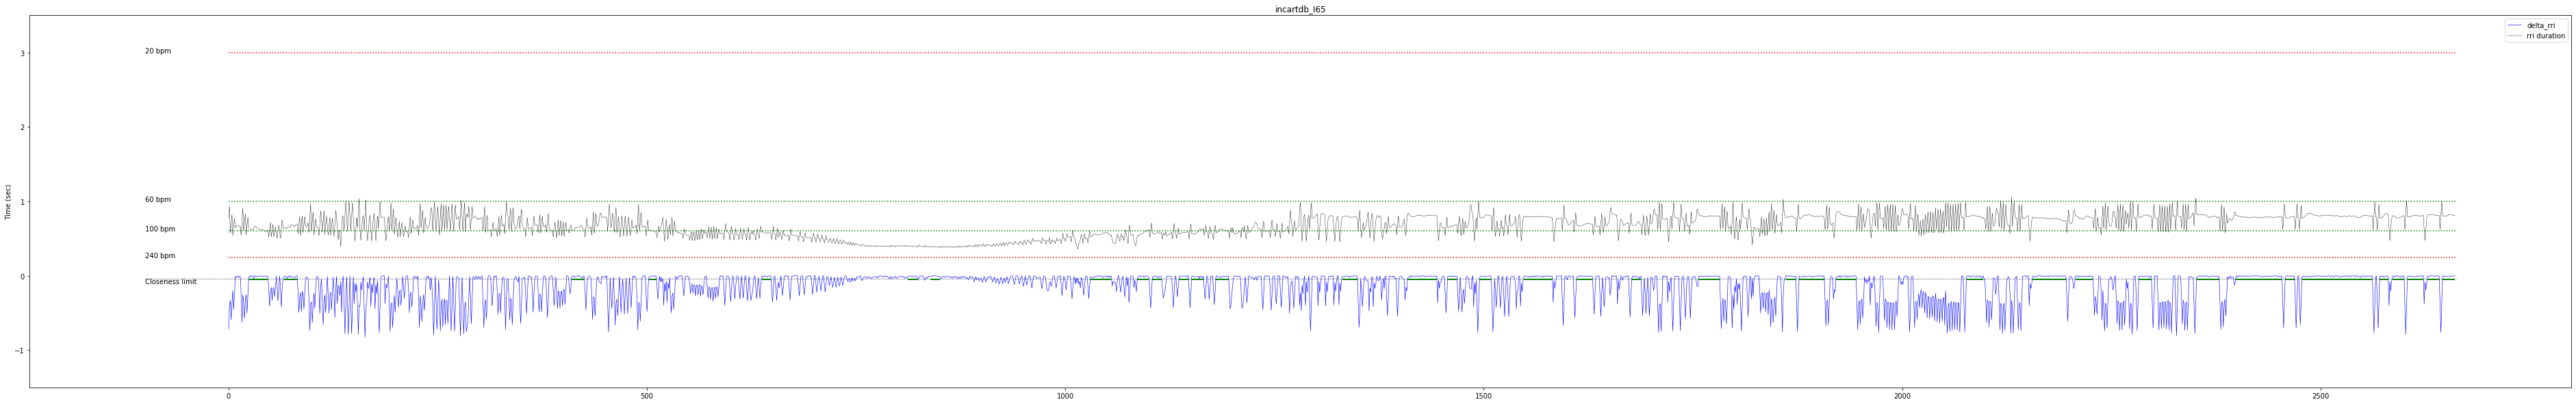

In [32]:
print('===================')
print (sel_rec.name)
print('===================')
# check RRI and BEAT INFO FOR WHOLE RECORDS
ff+=1
plt.figure(ff, figsize= ( rr_binfo.nos_rr_peaks/40 , 10))
plt.ylim((-1.5, max_rri+0.5))

#plt.scatter(np.arange(0,len(rri_delta),1),-1*np.abs(rri_delta) ,label='delta_rri', color='blue',marker = '+' )
plt.plot(-1*np.abs(rr_binfo.rri_delta) ,label='delta_rri', color='blue', linewidth = 0.6)
plt.plot(rr_binfo.rri_dur, label='rri duration', color='black', linewidth = 0.4)

plt.hlines(max_rri,0,rr_binfo.nos_rr_peaks,color='red', linestyles='dotted')
plt.annotate(str(H_min)+' bpm', xy=(-100,max_rri ))
plt.hlines(min_rri,0,rr_binfo.nos_rr_peaks,color='red', linestyles='dotted')
plt.annotate(str(H_max)+' bpm', xy=(-100,min_rri ))
plt.hlines(hig_rri,0,rr_binfo.nos_rr_peaks,color='green', linestyles='dotted')
plt.annotate(str(H_low)+' bpm', xy=(-100,hig_rri ))
plt.hlines(low_rri,0,rr_binfo.nos_rr_peaks,color='green', linestyles='dotted')
plt.annotate(str(H_hig)+' bpm', xy=(-100,low_rri ))

#plt.hlines(limit_delta_rri,0,nos_rr_peaks,color='red')
#plt.hlines(0,0,nos_rr_peaks,color='red')
plt.annotate('Closeness limit', xy=(-100,-limit_delta_rri-0.06 ))
plt.hlines(-limit_delta_rri,-100,rr_binfo.nos_rr_peaks,color='black', linestyles='dotted',linewidth=0.8)

plt.ylabel('Time (sec)')



for i in range(0, len(epiNorm)):
    #print(epiNorm[i])
    plt.hlines( -limit_delta_rri-0.01, epiNorm[i][0], epiNorm[i][1]-1 , color='green', linewidth = 2)
    #print(rr_binfo.rr_labels[epiNorm[i][0]-1:epiNorm[i][1]+1])

#plt.scatter( np.arange(0,rr_binfo.nos_rr_peaks,1)[norm_npy>0],norm_npy[norm_npy>0]  -0.95,marker='.', color='green' )
#plt.scatter( np.arange(0,rr_binfo.nos_rr_peaks,1)[close_npy>0],close_npy[close_npy>0]-1-limit_delta_rri  ,marker='.', color='blue')
#plt.scatter( np.arange(0,rr_binfo.nos_rr_peaks,1)[nac_npy>0],nac_npy[nac_npy>0]-1.75 , color='black',marker='.'  )
plt.title(sel_rec.name)
#plt.plot(norm_npy, linewidth=0.2, color='green')
#plt.plot(close_npy, linewidth=0.2, color='black')
#plt.plot(nac_npy, linewidth=0.2, color='blue')
plt.legend()


# -- Generate Median Beats for Normal Episodes

Normal episodes = 37
#epi	#beat	variance
0	22	0.0116
1	15	0.013588
2	14	0.01132
3	8	0.00684
4	10	0.012075
5	10	0.020265
6	10	0.011402
7	24	0.012971
8	13	0.008239
9	10	0.016482
10	10	0.00336
11	13	0.013981
12	14	0.00911
13	17	0.00416
14	34	0.003998
15	10	0.002499
16	13	0.002688
17	33	0.003937
18	18	0.002914
19	10	0.00801
20	24	0.002959
21	11	0.004758
22	29	0.004354
23	23	0.004137
24	19	0.006167
25	39	0.00301
26	20	0.005134
27	14	0.00412
28	26	0.005062
29	54	0.002663
30	10	0.002746
31	83	0.003067
32	9	0.002737
33	13	0.006272
34	18	0.00278
35	13	0.001419
36	14	0.001918
Variance : 0.0014187917816382766:0.020265435038665607
#beats : 8.0:83.0


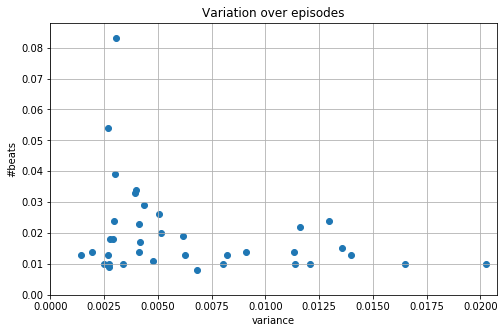

In [33]:
def gen_MMV(signal_array):
    #rr_binfo.rr_signal
    vdim = signal_array.shape[1]
    mean_beatX = np.zeros(vdim, dtype='float')
    median_beatX = np.zeros(vdim, dtype='float')
    var_beatX = np.zeros(vdim, dtype='float')
    for i in range(0,vdim):
        mean_beatX[i] = stats.mean(signal_array[:,i])
        median_beatX[i] = stats.median(signal_array[:,i])
        var_beatX[i] = stats.variance(signal_array[:,i] )
    return mean_beatX, median_beatX, var_beatX

# Representative episodal BEATS
medNorm = np.zeros((0,v_dim), dtype='float')
menNorm = np.zeros((0,v_dim), dtype='float')
varNorm = np.zeros((0,v_dim), dtype='float')
nos_epinorm = len(epiNorm)
print('Normal episodes = ' + str(nos_epinorm))
print('==================')
for ie in range(0,nos_epinorm):
    # select normal beats form this episode
    sigX = sigarr[ epiNorm[ie][0] + 1 : epiNorm[ie][1] - 1 ] # skip first and last
    # calculate mean, median, variance for each episode
    men_beatX, med_beatX, var_beatX =  gen_MMV(sigX)
    menNorm = np.vstack((menNorm, men_beatX))
    medNorm = np.vstack((medNorm, med_beatX))
    varNorm = np.vstack((varNorm, var_beatX))

escat = np.zeros((nos_epinorm, 2))
print('#epi\t#beat\tvariance')
for i in range(0, nos_epinorm):
    escat[i][0] = np.average(varNorm[i])        # variation
    escat[i][1] = (epiNorm[i][1]-epiNorm[i][0]) -2        # nos beats
    print(str(i)+'\t'+str(int(escat[i][1]))+'\t'+str(round(escat[i][0],6)))
plt.figure(0, figsize = (8,5))
plt.ylim(0, np.max(escat[:,1]) * 0.001 + 0.005  )
plt.xlim(0, np.max(escat[:,0]) + 0.0005 )
plt.title('Variation over episodes')
plt.xlabel('variance')
plt.ylabel('#beats')
plt.scatter(escat[:,0],escat[:,1]*0.001)
plt.grid('both')
#plt.legend()

epiN_max_variance = np.max(escat[:,0])
epiN_min_variance = np.min(escat[:,0])
epiN_max_nbeats = np.max(escat[:,1])
epiN_min_nbeats = np.min(escat[:,1])

print('Variance : '+ str(epiN_min_variance)+ ':'+str(epiN_max_variance))
print('#beats : '+ str(epiN_min_nbeats)+ ':'+str(epiN_max_nbeats))

# -- Select from Episode Medians (representative)

Episodes taken = 37


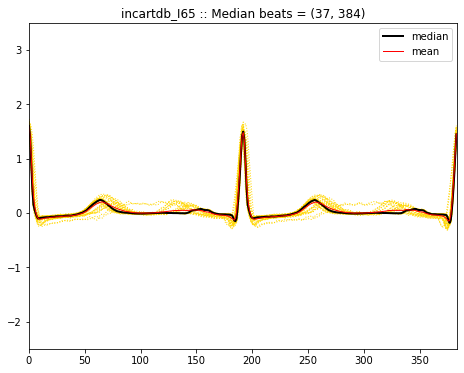

In [34]:

# out of all medan beats of all normal episode selete those with less variance
#for ie in range(0,nos_epinorm):
# take only 50% of episodes

sel_var_limit =  [epiN_min_variance, epiN_max_variance]
sel_nbeat_limit =  [epiN_min_nbeats,epiN_max_nbeats ]

sig_epi_rep = medNorm [(escat[:,0]>=sel_var_limit[0]) & 
                       (escat[:,0]<=sel_var_limit[1]) &
                       (escat[:,1]>=sel_nbeat_limit[0]) & 
                       (escat[:,1]<=sel_nbeat_limit[1])]

print('Episodes taken = '+ str(len(sig_epi_rep)))
if len(sig_epi_rep)<2:
    print('Selection is empty')
    quit
mean_of_med, med_of_med, _ =  gen_MMV(sig_epi_rep)

ff+=1
plt.figure(ff, figsize=plotdim_bfigsize)
plt.title(sel_rec.name + ' :: Median beats = '+ str(sig_epi_rep.shape))
plt.ylim(plotdim_bylim)
plt.xlim(0,v_dim)
for si in sig_epi_rep:
    plt.plot(si, linewidth =1, color='gold', linestyle='dotted')
#plt.plot(var_rep,linewidth = 1, color='blue', label = 'variance')
plt.plot(med_of_med,linewidth = 2, color='black', label = 'median')
plt.plot(mean_of_med,linewidth = 1, color='red', label = 'mean')
plt.legend()

# -- Compare abnormal episodes with representative beat

Abnormal beats = 59


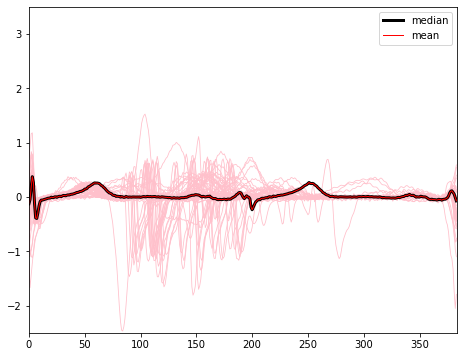

In [11]:
# abn BEATS
abn_query = (rr_binfo.rr_int_labels>0)
abn_where = np.where(abn_query)[0]
sigX = rr_binfo.rr_signal[abn_where]
print('Abnormal beats = ' + str(len(sigX)))

plt.figure(ff, figsize=plotdim_bfigsize)
plt.ylim(plotdim_bylim)
plt.xlim(0,v_dim)
for si in sigX:
    plt.plot(si, linewidth =0.8, color='pink')

plt.plot(med_of_med,linewidth = 3, color='black', label = 'median')
plt.plot(mean_of_med,linewidth = 1, color='red', label = 'mean')
plt.legend()


# -- Test Median of other classes

MATCHING BEATS# (1083, 384)


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


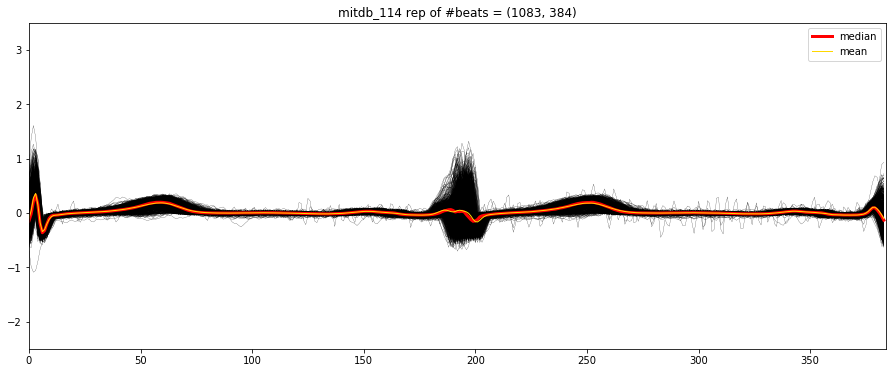

In [19]:
# CLOSED AND NORMAL
epi_query = (rr_binfo.rr_int_labels==0) & (np.abs(rr_binfo.rri_delta)<=limit_delta_rri)
epi_where = np.where(epi_query)[0]
sigCN = sigarr[epi_where]
print('MATCHING BEATS# '+ str(sigCN.shape))

ff+=1
plt.figure(ff, figsize=(plotdim_bfigsize[0]*2,plotdim_bfigsize[1]))
plt.title(sel_rec.name+ ' rep of #beats = '+ str(sigCN.shape))
plt.ylim(plotdim_bylim)
plt.xlim(0,v_dim)
for si in sigCN:
    plt.plot(si, linewidth =0.2, color='black')

med_beatCN = np.zeros(v_dim, dtype='float')
men_beatCN = np.zeros(v_dim, dtype='float')
for i in range(0,v_dim):
    med_beatCN[i] = stats.median( sigCN [:,i])
    men_beatCN[i] = stats.mean( sigCN [:,i])
plt.plot(med_beatCN,linewidth = 3, color='red', label = 'median')
plt.plot(men_beatCN,linewidth = 1, color='gold', label = 'mean')
plt.legend()

# N__MODEL

In [0]:

# 3.2 :: define network models
cost = 'sparse_categorical_crossentropy'
opt = 'rmsprop'
# otherwise Create a loss function
def closs(y_true,y_pred):
    return kbend.mean(kbend.abs(y_pred - y_true),axis=-1)

# call back
cb_esr = tf.keras.callbacks.EarlyStopping(
        monitor='acc', 
        min_delta=0.000001, 
        patience=2, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        restore_best_weights=False)
cb_listr=[cb_esr] 


def get_model(print_summary, input_shape_base,input_shape_compared):

# BASE INPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    ibase = Input( shape=input_shape_base, name = "input_basic" )

    conv_base_1 =  Conv1D(20,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (ibase) 
    
    maxpool_base_2 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_base_1)
    
    conv_base_3 =  Conv1D(15,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (maxpool_base_2)
    
    maxpool_base_4 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_base_3)
    conv_base_5 =  Conv1D(8,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (maxpool_base_4)
    
    maxpool_base_6 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_base_5)
    
    flat_base_7 = Flatten(data_format=None) (maxpool_base_6)
    den_base_8 = Dense(20, activation=tf.nn.leaky_relu, name = "dense_basic") (flat_base_7)



# COMPAR INPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    icompar = Input( shape=input_shape_compared, name = "input_compar" )

    conv_icompar_1 =  Conv1D(20,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (icompar) 
    
    maxpool_icompar_2 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_icompar_1)
    
    conv_icompar_3 =  Conv1D(15,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (maxpool_icompar_2)
    
    maxpool_icompar_4 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_icompar_3)
    conv_icompar_5 =  Conv1D(8,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None) (maxpool_icompar_4)
    
    maxpool_icompar_6 = MaxPooling1D(pool_size=2, 
                                  strides=None, 
                                  padding='valid', 
                                  data_format='channels_last') (conv_icompar_5)
    
    flat_icompar_7 = Flatten(data_format=None) (maxpool_icompar_6)
    den_icompar_8 = Dense(20, activation=tf.nn.leaky_relu, name = "dense_compar") (flat_icompar_7)

# CONCAT LAYER SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    den_concat =  tf.concat([den_base_8,den_icompar_8],axis=1, name = "dense_concat") # should have 40 nodes

# DENSE SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    den_fc0 = Dense(20, activation=tf.nn.relu, name = "DENSE_FC0")(den_concat)
    
    den_fc1 = Dense(10, activation=tf.nn.relu, name = "DENSE_FC1")(den_fc0)

# OUTPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    den_out = Dense(2, activation=tf.nn.softmax, name = "OUTPUT_FC")(den_fc1)

# =========================================================================================
    model=Model(inputs=[ibase,icompar], outputs=den_out)
    #-------------------------------------
    #model.get_layer(name="LSTM_50").trainable=is_trainable
    #-------------------------------------
    model.compile(loss=cost, optimizer=opt, metrics=['accuracy'])
    if print_summary:
        print(model.summary())
    return model
#==============================================================================


# PREPARE DATA

Get Data for N and A labels. 

While Training with median beat, data from Normal and Closed episodes should be used.

While Testing, data from all parts of the records should be used

Nos [N] = 1083
Nos [A] = 59
Vector Dim: 384
Training Data Ratio 0.5
Training: (58, 386)
Testing: (1084, 386)


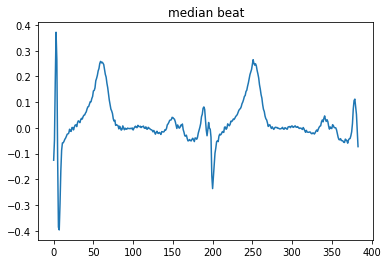

In [21]:
# 1 choose the median representative beat
data_med = med_of_med # mean_of_med or med_of_med
plt.plot(data_med)
plt.title('median beat')
# select train:test ration and load signal
train_ratio = 0.5 #<-- for training : testing
sigarr = rr_binfo.rr_signal

# 2 SELECT NORMAL BEATS
#N_where = np.where(rr_binfo.rr_int_labels==0)[0] # <<===== for testing use all N beats
N_where = nac_where # <<========for training use only NAC beats
data_compar_N = sigarr[N_where] 
data_peak_N = np.expand_dims(rr_binfo.rr_peaks[N_where],axis=1)
data_label_N = np.expand_dims(rr_binfo.rr_int_labels[N_where],axis=1)

# 3 SELECT ABNORMAL BEATS
A_where = np.where(rr_binfo.rr_int_labels>0)[0]
data_compar_A = sigarr[A_where]
data_peak_A = np.expand_dims(rr_binfo.rr_peaks[A_where],axis=1)
data_label_A = np.expand_dims(rr_binfo.rr_int_labels[A_where],axis=1)

#================ CONCATENATE DATA AND META INFO
data_N = np.concatenate( (data_peak_N, data_label_N, data_compar_N ) , axis = 1)
data_A = np.concatenate( (data_peak_A, data_label_A, data_compar_A ) , axis = 1)

#--------------- may shuffle each lable to choose randomly from full record
do_shuf=2
for i in range(0,do_shuf):
    np.random.shuffle(data_N)
    np.random.shuffle(data_A)

##================ DIVIDE DATA INTO TRAIN:TEST
nos_N = len(data_N)
nos_A = len(data_A)
print('Nos [N] = '+ str(nos_N))
print('Nos [A] = '+ str(nos_A))
take_NA = int(train_ratio* min(nos_N, nos_A))


data_test = np.vstack( (  data_N[take_NA:], data_A[take_NA:]  ) ) #========== # TESTING DATA     
data_train = np.vstack( (  data_N[0:take_NA], data_A[0:take_NA]  ) )   #=========# TRAINING DATA
do_shuf = 5
for i in range(0,do_shuf):
    np.random.shuffle(data_train)        # shuffle training data
    #np.random.shuffle(data_test)          # no need to shuffle testing data


#================================================= PRINT RESULTS
print('Vector Dim: ' + str(v_dim))
print('Training Data Ratio ' + str(train_ratio))
print('Training: '+ str(data_train.shape))
print('Testing: ' + str(data_test.shape))

# [A] LOAD TRAINING SET

In [22]:
#==============================================================================
# use dataA array
Dp = data_train[:,0]
Dy = data_train[:,1]
Dx = data_train[:,2:]
Dm = np.zeros((0,v_dim),dtype='float')
for i in range(0, len(data_train)):
    Dm = np.vstack((Dm,data_med))
#===========================================================================================
dlen = len(Dy)
Dm = Dm.reshape( dlen, v_dim,1)  #np.expand_dims(Dm, axis=-1)
Dx = Dx.reshape( dlen, v_dim,1) #np.expand_dims(Dx, axis=-1)
data_x = [Dm, Dx]
data_y = Dy

print(Dx.shape)
print(Dm.shape)
print('Loaded beats: ' + str(Dy.shape))

(58, 384, 1)
(58, 384, 1)
Loaded beats: (58,)


# [a] PERFORM TRAINING

In [0]:
dirfs = os.listdir(global_modeldir)
print('Dir = '+str(global_modeldir))
print('Files = '+str(len(dirfs)))
for d in dirfs:
    print(d)

Dir = /content/drive/My Drive/Masters/workdir/ecg_data/db_model
Files = 1
cnn_median_model.h5


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_basic (InputLayer)        [(None, 384, 1)]     0                                            
__________________________________________________________________________________________________
input_compar (InputLayer)       [(None, 384, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 382, 20)      80          input_basic[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 382, 20)      80          input_compar[0][0]               
_____________

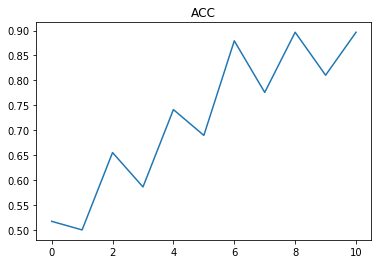

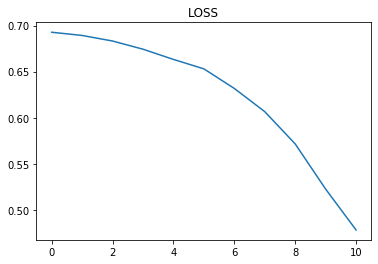

In [23]:
save_model_name = 'cnn_median_model'+'.h5'

model = get_model(True, (v_dim,1), (v_dim,1))
history = model.fit(
                    data_x, data_y,
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)

plt.figure(0)
plt.title('ACC')
plt.plot(history.history['acc'])

plt.figure(1)
plt.title('LOSS')
plt.plot(history.history['loss'])

#save this model
model.save_weights(os.path.join(global_modeldir, save_model_name))
print('Saved Model : '+save_model_name )

# [B] LOAD TEST SET

In [24]:
#==============================================================================
# use dataB array
Dp = data_test[:,0]
Dy = data_test[:,1]
Dx = data_test[:,2:]
Dm = np.zeros((0,v_dim),dtype='float')
for i in range(0, len(data_test)):
    Dm = np.vstack((Dm,data_med))
#===========================================================================================
dlen = len(Dy)
Dm = Dm.reshape( dlen, v_dim,1)  #np.expand_dims(Dm, axis=-1)
Dx = Dx.reshape( dlen, v_dim,1) #np.expand_dims(Dx, axis=-1)
data_x = [Dm, Dx]
data_y = Dy

print(Dx.shape)
print(Dm.shape)
print('Loaded beats: ' + str(Dy.shape))


(1084, 384, 1)
(1084, 384, 1)
Loaded beats: (1084,)


# [b] PERFORM TESTING

b.0. List available models

In [0]:
dirfs = os.listdir(global_modeldir)
print('Dir = '+str(global_modeldir))
print('Files = '+str(len(dirfs)))
for d in dirfs:
    print(d)

Dir = /content/drive/My Drive/Masters/workdir/ecg_data/db_model
Files = 1
cnn_median_model.h5


b.1. Choose a model for testing

In [0]:
#get the model - skip this to use the on same model as on training
model = get_model(False, (v_dim,1), (v_dim,1))
model.load_weights(os.path.join(global_modeldir, 'cnn_median_model' + '.h5'))

b.2. AUTO EVAL

In [25]:
# auto evaluate
model.evaluate( x=data_x, y=data_y )

1084/1084 [==============================] - 0s 352us/sample - loss: 0.2265 - acc: 0.9852


[0.22654055647304577, 0.98523986]

b.3. PREDICTION

In [26]:
# manual prediction
print('REC = ' + rr_binfo.rec.name)
g_LABELS= ['N','A']
#evla = model.evaluate( data_x, data_y ) data_med med_rep
#print(evla)
#print ('Predict on dataset '+ sel_ds + ' using model ' + global_model_name) 
predx = model.predict( data_x ) # array of  samples x classes(4) - each row is a prediction of sample
cmx_global = np.zeros((2,2),dtype='int32')
cmx2_global = predx.argmax(axis=1)
for i in range(0,len(cmx2_global)):
    alabel = int(data_y[i])
    plabel = cmx2_global[i]
    cmx_global[alabel,plabel]+=1
print('\tConfusion Matrix')
print(print_conf_matrix( cmx_global,'', g_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(cmx_global) ,g_LABELS ) 

REC = mitdb_114
	Confusion Matrix
A\P	N	A
N	1054	0
A	16	14

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.99	0.99	1.0	0.47
A	0.99	1.0	0.47	1.0


# [C] PLOT RESULTS

# [ * ONE TIME * ] DB Building

In [0]:
#    C A R E F U L   D O N T     R U N    T H I S 
#---------------------------------------------
approach = 1  # select Filtering approach
db_data = all_db.values()
#---------------------------------------------------------------------------------------------------------------------------------------------
# Database Building Functions
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 1 Build Annotations :: a.txt -> ant.npy
def build_db_ants(self_db, output_postfix_beat,output_postfix_nonbeat, gmaps):  
#---------------------------------------------------------------------------------------------------------------------------------------------
    #global g_map_keys
    #global g_map
    gmaps_keys = gmaps.keys()
    xs=len(self_db.recs)
    #xc=1
    print('\nBEGIN TASK :: Build annotations for ' + str(xs)+ ' records')
    print('REC\tFound\tBEAT\tNONB' )
    for rec in self_db.recs:
        #print('REC: '+rec+ '...'+str(xc)+ ' of '+ str(xs))
        #xc+=1
        ants = np.loadtxt(os.path.join(self_db.dir_mat , rec + 'a.txt'), dtype='str', delimiter= '\n', skiprows = 1)
        #print('\tFound Annotations\t'+str(len(ants)))
        antsbeat = np.zeros((0,2),dtype='str')
        antsnonbeat = np.zeros((0,2),dtype='str')
        #print('  annotations found '+str(len(ants)))
        for i in range(0,len(ants)):
            a_a = ants[i].split()
            a_sample = a_a[1]
            a_label = a_a[2]
            
            if a_label in gmaps_keys:
                bmaped = gmaps[a_label]
                if bmaped >= g_LMIN:
                    antsbeat = np.vstack((antsbeat,np.array([a_sample,a_label]))) # sample,label str
                else: # is non beat
                    antsnonbeat = np.vstack((antsnonbeat,np.array([a_sample,a_label]))) # sample,label str
            else:
                print('\tWARNING :: Unknown annotation "'+a_label+'" found at [' +a_sample+ '] in file a.txt, skipping....')
        
        #adf =  len(ants) - len(antsnpy) 
        #print('\tKnown Annotations\t'+str(len(antsnpy)))
        # print('\tUnknown Annotations\t'+str(adf))
        print(rec + '\t'+ str(len(ants)) + '\t'+str(len(antsbeat))+'\t' + str(len(antsnonbeat) ))
        # save for this record
        np.save(os.path.join(self_db.dir_npy , rec+ '_'+output_postfix_beat+'.npy'), antsbeat)
        np.save(os.path.join(self_db.dir_npy , rec+ '_'+output_postfix_nonbeat+'.npy'), antsnonbeat)
        #print('\tSaved at "'+save_loc+'"')
    print('\nEND TASK :: Build annotations for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 2 Extract Raw lead2 signal :: m.mat[lead2] -> raw2.npy
def build_db_signal(self_db, output_postfix, lead_indices):  # saves xm.mat[lead2] --> x_raw2.npy
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    print('\nBEGIN TASK :: Save signal data for ' + str(xs)+ ' records')
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        mat_signal = loadmat(os.path.join( self_db.dir_mat , rec + 'm.mat'))['val']#[self_db.lead2_index]
        for li in range(0,len(lead_indices)):
            np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix[li]+'.npy'), mat_signal[lead_indices[li]])    
    print('END TASK :: Save signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# 3a Filter Raw/Denoised signal :: raw2.npy -> med2.npy or den2.npy -> rmd2.npy
def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix): 
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    mfa = np.zeros(len(ms_flt_array), dtype='int')
    #print('fun')
    for i in range(0, len(ms_flt_array)):
        mfa[i] = get_median_filter_width(self_db.srate,ms_flt_array[i])
        #print('loop')
    print('\nBEGIN TASK :: filer signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy')) #np.save(rec_fnpy + '_raw2.npy', mat_signal) 
        X_med2 = filter_signal(X, mfa)
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_med2) # save a copy of (median filtered ) signal = r,m  
        #----------------------------------------------------------------------         
    print('END TASK :: filer signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------------------------------------------------------
# 3b Denoise Raw/Filtered signal :: med2.npy -> rdm2.npy or raw2.npy -> den2.npy
def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
#---------------------------------------------------------------------------------------------------------------------------------------------
    xs=len(self_db.recs)
    xc=0
    
    print('\nBEGIN TASK :: denoising signal data for ' + str(xs)+ ' records:' + input_postfix + ' --> ' + output_postfix)
    for rec in self_db.recs:
        xc+=1
        print('Rec: '+rec+ ' ... '+ str(xc)+' of '+ str(xs))
        X = np.load(os.path.join( self_db.dir_npy , rec + '_'+input_postfix+'.npy') ) # np.load(self_db.dir_npy + rec + '_raw2.npy')
        X_rlt2 = denoise_signal(X,dwt_transform, dlevels, cutoff_low, cutoff_high )
        np.save(os.path.join( self_db.dir_npy , rec + '_'+output_postfix+'.npy'),X_rlt2) # save a copy of (only denoised)  signal = r,m,d 
        #----------------------------------------------------------------------         
    print('END TASK :: denoising signal data for ' + str(xs)+ ' records')
    return 0
#---------------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------------

print(datetime.datetime.now())
print('S T A R T \n')

for db in db_data:
#=========================================================================================
    print ('\n START ON DATABASE: '+ db.name +' \t'+ str(datetime.datetime.now()))
    directory = os.makedirs(os.path.join(global_npydir, db.name+'_npy') , exist_ok = True) 
#=========================================================================================

#=========================================================================================
# STEP 0 : (REQUIRED : Annotation data)
#=========================================================================================
    print ('\n COPY ANNOTATIONS \t'+ str(datetime.datetime.now()))
    # def build_db_ants(self_db, output_postfix):
    build_db_ants(db, g_BEAT_POSTFIX,g_NBEAT_POSTFIX, g_map)  


#=========================================================================================
# STEP 1 : (REQUIRED : Signal Data)
#=========================================================================================
    print ('\n EXTRACT RAW SIGNAL \t'+ str(datetime.datetime.now()))
    # def build_db_signal(self_db, output_postfix, lead_indices):  # saves xm.mat[lead2] --> x_raw2.npy
    # use build_db_signal(db, [g_RAW?_POSTFIX],[db.lead?_index]) 
    build_db_signal(db, [g_RAW2_POSTFIX],[db.lead2_index])
    build_db_signal(db, [g_RAW5_POSTFIX],[db.lead5_index]) 

#=========================================================================================
# STEP 3 : (Preprocessing)
#=========================================================================================
    print ('\n FILTER :: RAW -> MED \t'+ str(datetime.datetime.now()))
    # def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix): 
    filter_db_signal(db, [0.2,0.6], g_RAW2_POSTFIX, g_MED2_POSTFIX) 
    filter_db_signal(db, [0.2,0.6], g_RAW5_POSTFIX, g_MED5_POSTFIX) 

    if approach==0:
        # STEP 3.a : First 'median Filter' the signal then 'denoise' it
        #=========================================================================================
        print ('\n DENOISE :: MED -> FLT \t'+ str(datetime.datetime.now()))
        # def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_MED2_POSTFIX, g_FLT2_POSTFIX )
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_MED5_POSTFIX, g_FLT5_POSTFIX )
        
    else:
        # STEP 3.b : First 'denoise' the signal then 'median filter' it
        #=========================================================================================
        print ('\n DENOISE :: RAW -> DEN \t'+ str(datetime.datetime.now()))
        # def denoise_db_signal(self_db, dwt_transform, dlevels, cutoff_low, cutoff_high, input_postfix, output_postfix):
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_RAW2_POSTFIX, g_DEN2_POSTFIX )
        denoise_db_signal(db, 'bior4.4', 11 , 2 , 9, g_RAW5_POSTFIX, g_DEN5_POSTFIX )
        print ('\n FILTER :: DEN -> FLT \t'+ str(datetime.datetime.now()))
        # def filter_db_signal(self_db, ms_flt_array, input_postfix, output_postfix):  
        filter_db_signal(db, [0.2,0.6], g_DEN2_POSTFIX, g_FLT2_POSTFIX) 
        filter_db_signal(db, [0.2,0.6], g_DEN5_POSTFIX, g_FLT5_POSTFIX) 
        
    
#=========================================================================================
    print ('\n END ON DATABASE:'+ db.name +' \t'+ str(datetime.datetime.now()))
#=========================================================================================
print('\n E N D ')
print(datetime.datetime.now())
#    C A R E F U L   D O N T     R U N    T H I S 




2020-03-11 05:38:10.363280
S T A R T 


 START ON DATABASE: mitdb 	2020-03-11 05:38:10.364474

 COPY ANNOTATIONS 	2020-03-11 05:38:10.365783

BEGIN TASK :: Build annotations for 41 records
REC	Found	BEAT	NONB
210	2685	2650	35
124	1634	1619	15
208	3040	2955	85
215	3400	3363	37
103	2091	2084	7
230	2466	2256	210
115	1962	1953	9
209	3052	3005	47
234	2764	2753	11
117	1539	1535	4
101	1874	1865	9
105	2691	2572	119
220	2069	2048	21
222	2634	2483	151
232	1816	1780	36
219	2312	2154	158
213	3294	3251	43
118	2301	2278	23
108	1824	1763	61
113	1796	1795	1
223	2643	2605	38
100	2274	2273	1
203	3108	2980	128
202	2146	2136	10
111	2133	2124	9
116	2421	2412	9
123	1519	1518	1
214	2297	2262	35
228	2141	2053	88
201	2039	1963	76
205	2672	2656	16
119	2094	1987	107
122	2479	2476	3
200	2792	2601	191
106	2098	2027	71
121	1876	1863	13
114	1890	1879	11
233	3152	3079	73
112	2550	2539	11
221	2462	2427	35
109	2535	2532	3

END TASK :: Build annotations for 41 records

 EXTRACT RAW SIGNAL 	2020-03-11 05:38:12.262200

BE

# --- ARCHIVE ---

In [0]:
# stacking inputs
j = np.arange(0,12,1).reshape(4,3)
j1 = np.expand_dims(np.arange(100,104,1), axis=1)
j2 = np.expand_dims(np.arange(-54,-50,1), axis=1)
print(j.shape)
print(j)

print(j1.shape)
print(j1)
print(j2.shape)
print(j2)

k = np.concatenate( (j1, j2, j ) , axis = 1)
print(k.shape)
print(k)

np.random.shuffle(k)
print(k.shape)
print(k)


# -- REPRESENTATIVE BEATS

In [12]:
# NORMAL BEATS
sigN = sigarr[np.where(norm_npy==1)[0][1:-1]]
print('Normal beats = '+ str(sigN.shape))
ff+=1
plt.figure(ff, figsize=plotdim_bfigsize)
plt.title(sel_rec.name + ' :: N beats = '+ str(sigN.shape))
plt.ylim(plotdim_bylim)
plt.xlim(0,v_dim)
for si in sigN:
    plt.plot(si, linewidth =0.2, color='black')

med_beatN = np.zeros(v_dim, dtype='float')
men_beatN = np.zeros(v_dim, dtype='float')
for i in range(0,v_dim):
    med_beatN[i] = stats.median( sigN [:,i])
    men_beatN[i] = stats.mean( sigN [:,i])
plt.plot(med_beatN,linewidth = 3, color='red', label = 'median')
plt.plot(men_beatN,linewidth = 1, color='gold', label = 'mean')
plt.legend()

NameError: ignored

In [0]:
# CLOSED BEATS
sigC = sigarr[np.where(close_npy==1)[0][1:-1]]
print('Closed beats = '+ str(sigC.shape))
ff+=1
plt.figure(ff, figsize=plotdim_bfigsize)
plt.title(sel_rec.name+ ' :: C beats = '+ str(sigC.shape))
plt.ylim(plotdim_bylim)
plt.xlim(0,v_dim)
for si in sigC:
    plt.plot(si, linewidth =0.2, color='black')

med_beatC = np.zeros(v_dim, dtype='float')
men_beatC = np.zeros(v_dim, dtype='float')
for i in range(0,v_dim):
    med_beatC[i] = stats.median( sigC [:,i])
    men_beatC[i] = stats.mean( sigC [:,i])
plt.plot(med_beatC,linewidth = 3, color='red', label = 'median')
plt.plot(men_beatC,linewidth = 1, color='gold', label = 'mean')
plt.legend()

In [0]:
# ABNORMAL
sigA = sigarr[np.where(norm_npy==0)[0][1:-1]]
print('Abnormal = '+ str(sigA.shape))

ff+=1
plt.figure(ff, figsize=plotdim_bfigsize)
plt.title(sel_rec.name+ ' :: N ^ C beats = '+ str(sigA.shape))
plt.ylim(plotdim_bylim)
plt.xlim(0,v_dim)
for si in sigA:
    plt.plot(si, linewidth =0.2, color='black')

med_beatA = np.zeros(v_dim, dtype='float')
men_beatA = np.zeros(v_dim, dtype='float')
for i in range(0,v_dim):
    med_beatA[i] = stats.median( sigA [:,i])
    men_beatA[i] = stats.mean( sigA [:,i])
plt.plot(med_beatA,linewidth = 3, color='red', label = 'median')
plt.plot(men_beatA,linewidth = 1, color='gold', label = 'mean')
plt.legend()

# -- COMPARE REP BEAT [NC v/s A]

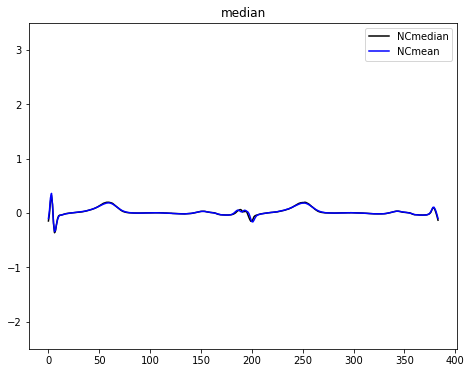

In [14]:
plt.figure(0,figsize=plotdim_bfigsize)
plt.title('median')
plt.ylim(plotdim_bylim)
plt.plot(med_beatCN,color= 'black',label = 'NCmedian')
#plt.plot(med_beatC,linewidth=0.8, color= 'black',label = 'C')
#plt.plot(med_beatN,linewidth=0.8, color= 'green',label = 'N')
#plt.plot(med_beatA,linewidth=0.5, color= 'red',label = 'A')
#plt.legend()



#plt.figure(1,figsize=plotdim_bfigsize)
#plt.title('mean')
#plt.ylim(plotdim_bylim)
plt.plot(men_beatCN,color= 'blue',label = 'NCmean')
#plt.plot(men_beatC,linewidth=0.8, color= 'black',label = 'C')
#plt.plot(men_beatN,linewidth=0.8, color= 'green',label = 'N')
#plt.plot(men_beatA,linewidth=0.5, color= 'red',label = 'A')
plt.legend()

In [0]:
def get_episodes(A, min_epi_len, int_label, vb):
    res = []
    state = False
    ii=0
    #A = self.rr_int_labels
    AA=np.hstack( ( np.array([int_label]), A, np.array([int_label]) ) )
    lena = len(AA)
    while (True):
        if not state:
            ii+=1
            if ii >= lena:
                if len(res)>0:
                    if len(res[-1]) < min_epi_len:
                        res.pop()
                break
            if AA[ii]!=int_label:
                # before appending new - check if prev was moew than len
                if len(res)>0:
                    if len(res[-1]) < min_epi_len:
                        if vb:
                            print('CLEAR_STACK: '+ str(len(res[-1])) + '\t'+str(res[-1]) + ' is < '+str(min_epi_len))
                        res[-1].clear()
                        
                    else:
                        res.append([])
                else:
                    res.append([])
                
                state=True
        else:
            res[-1].append(ii-1) # -1 because u padded it
            if vb:
                print('APPEND_STACK: '+ str(len(res[-1])) + '\t'+str(res[-1]))
            ii+=1
            if AA[ii]==int_label:
                state=False 
    if vb:
        print('')
        print(res)
    return res

In [0]:
#sigR = np.arange(0,v_dim,1)
sigR = np.zeros(v_dim)
sigR = np.expand_dims(sigR,axis=0)

data = sigR

predic = model.predict(data)

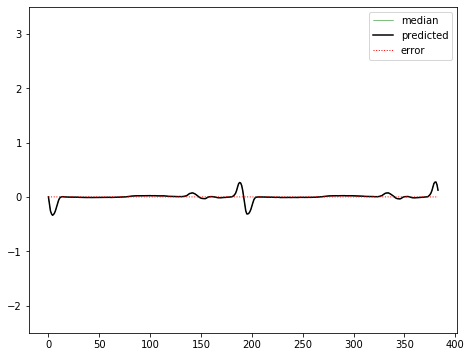

In [0]:
plt.figure(0,figsize=plotdim_bfigsize)
plt.ylim(plotdim_bylim)
plt.plot(med_rep,color='green',label='median', linewidth ='0.5')
for i in predic:
    plt.plot(i,color='black',label = 'predicted')
    plt.plot(med_rep -i, color='red', linewidth=1, label='error', linestyle='dotted' )
plt.legend()

0


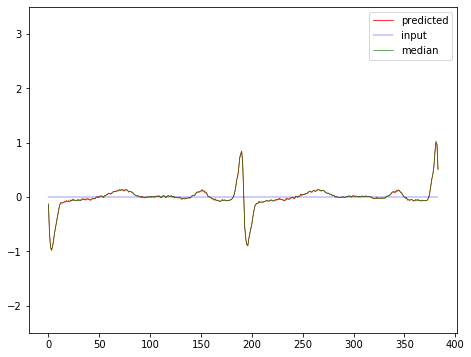

In [0]:
plt.figure(0,figsize=plotdim_bfigsize)
plt.ylim(plotdim_bylim)
sii = random.randint(0, len(data)-1)
print(str(sii))
plt.plot(predic[sii],linewidth = 0.8, color='red',label = 'predicted')
plt.plot(data[sii],linewidth = 0.4, color='blue',label = 'input')
plt.plot(med_rep,linewidth = 0.6, color='green',label = 'median')
plt.legend()

incartdb_I48
v dim = 384
N, 0.632295719844358 sec


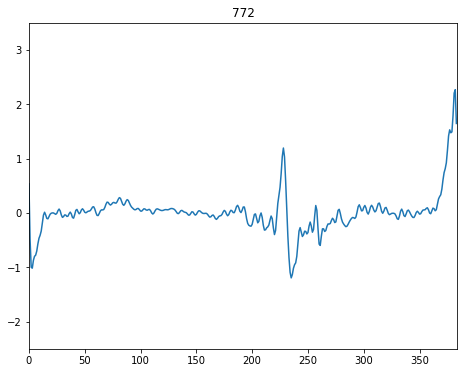

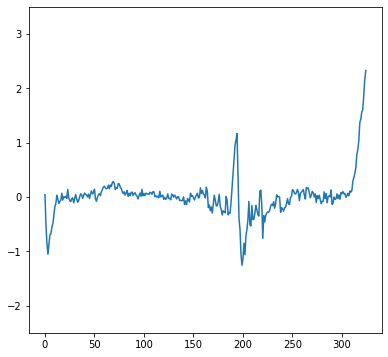

In [0]:
print(sel_rec.name)
print('v dim = ' + str(v_dim))
sigarr = rr_binfo.rr_signal

ii = random.randint(0, len(sigarr)-1)
ss = sigarr[ii]

plt.figure(0, figsize=plotdim_bfigsize)
plt.plot(ss)
plt.title(str(ii))
plt.ylim(plotdim_bylim)
plt.xlim(0,v_dim)
print( str( rr_binfo.rr_labels[ii] ) +", " + str(rr_binfo.rri_dur[ii] ) +' sec' )

view_beat(1, sel_rec, rr_binfo.rr_peaks[ii], g_MED2_POSTFIX )

In [0]:



    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
def closs(y_true,y_pred):
    return kbend.mean(kbend.abs(y_pred - y_true),axis=-1)
   
# now train an autoencoder to memorize normal - build a filter
#v_dim
#sigN
#med_beat
#men_beat

model = Sequential()
model.add(Dense(100, activation='tanh', input_dim=v_dim))

model.add(Dense(50, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
#model.add(Dense(50, activation='sigmoid'))
#model.add(Dense(300, activation='sigmoid'))

model.add(Dense(v_dim, activation='tanh'))   # sigmoid
model.compile(optimizer='rmsprop',
              loss=closs,
              metrics=['accuracy'])
print(model.summary())
data = sigCN
#labels = np.expand_dims(med_beatCN,axis=0)
labels = np.zeros((0,v_dim),dtype='float')
for dl in range(0,len(data)):
    labels= np.vstack((labels,med_rep))
#print(labels)
print(labels.shape)
print(data.shape)
#model.fit(data, labels, epochs=10, batch_size=32,metrics=['accuracy'])

his = model.fit(data, labels, epochs=1, validation_data=(data,labels))
las_acc = his.history['acc'][0]
las_loss = his.history['loss'][0]
las_vacc = his.history['val_acc'][0]
las_vloss = his.history['val_loss'][0]
print(str(his.history))
#cacc = las_loss
pati=4
itr_C = 0
cpati=3
vhist = []
print('=======================================================\n')
while True:
    itr_C+=1
    
    his = model.fit(data, labels, epochs=1, verbose=0) #validation_data=(data,labels),
    #i_acc = his.history['acc'][0]
    i_loss = his.history['loss'][0]
    print('[ '+str(itr_C)+' ]-------------Loss: '+str(i_loss))
    #i_vacc = his.history['val_acc'][0]
    #i_vloss = his.history['val_loss'][0]
    vhist.append(i_loss)
    #print('Loss: '+str(i_loss))
    if i_loss >= las_loss : # loss has not decreased
        print('Loss not decreasing...')
        if cpati==0:
            print('No more patience, end training')
            break
        else:
            cpati-=1
            print('used 1 patience, remaining patience = '+ str(cpati))
    
    else:
        # loss decreased pateince restored
        cpati=pati
        las_loss = i_loss

print( ' ! EXIT LOOP !')
print(str(his.history))
plt.plot(vhist)
#plt.plot(his.history['acc'],label='acc')
#plt.plot(his.history['val_acc'],label='val_acc')
#plt.legend()